In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA as mlabPCA
import seaborn as sns
import math
import scipy.stats as stats
import statsmodels.formula.api as smf
import calendar
import time
import glob
import gc
import os
import warnings
import locale
from IPython.display import display
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## DS_2_4_2 DATA CLEANUP AND EXPLORATION

In [2]:
#These are already included in data text file. Just added here for reference.
my_cols = [
            'City',
            'Pop',
            'Violent_cr',
            'Mrdr_manslter',
            'Rape1',
            'Rape2',
            'Robbery',
            'Agg_asslt',
            'Prop_cr',
            'Burg',
            'Larc_thft',
            'Mtr_vhcl_thft',
            'Arson3'
            ]
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')
df = pd.read_csv("crime_data_ny_2013.txt",encoding="utf-8", thousands=',')
df.replace('', np.nan, inplace=True)
df.fillna(0,inplace=True)
df = df.astype({            
                'City':'object',
                'Pop':'int64',
                'Violent_cr':'int64',
                'Mrdr_manslter':'int64',
                'Rape1':'int64',
                'Rape2':'int64',
                'Robbery':'int64',
                'Agg_asslt':'int64',
                'Prop_cr':'int64',
                'Burg':'int64',
                'Larc_thft':'int64',
                'Mtr_vhcl_thft':'int64',
                'Arson3':'int64'
                })
df["Pop_squared"] = np.square(df["Pop"])
df2 = df.loc[((df["City"] != "")), [
                                    "City",
                                    "Pop",
                                    "Pop_squared",   
                                    "Violent_cr",
                                    "Mrdr_manslter",
                                    "Rape2", 
                                    "Robbery",
                                    "Agg_asslt",
                                    "Burg",
                                    "Larc_thft",
                                    "Mtr_vhcl_thft", 
                                    "Prop_cr"
                                    ]]
df_jittered2 = df2
df_jittered2.shape[0]
df_jittered2['Pop'] = df.apply(lambda x: 100000 if x['Pop'] > 100000 else x['Pop'], axis=1)
df_jittered2['Pop_squared'] = df.apply(lambda x:  7000000000 if x['Pop_squared'] >  7000000000 else x['Pop_squared'], axis=1)
df_jittered2['Violent_cr'] = df.apply(lambda x: 400 if x['Violent_cr'] > 400 else x['Violent_cr'], axis=1)
df_jittered2['Agg_asslt'] = df.apply(lambda x: 50 if x['Agg_asslt'] > 50 else x['Agg_asslt'], axis=1)
df_jittered2['Burg'] = df.apply(lambda x: 400 if x['Burg'] > 400 else x['Burg'], axis=1)
df_jittered2['Larc_thft'] = df.apply(lambda x: 800 if x['Larc_thft'] > 800 else x['Larc_thft'], axis=1)
df_jittered2['Mtr_vhcl_thft'] = df.apply(lambda x: 100 if x['Mtr_vhcl_thft'] > 100 else x['Mtr_vhcl_thft'], axis=1)
df_jittered2['Prop_cr'] = df.apply(lambda x: 2000 if x['Prop_cr'] > 2000 else x['Prop_cr'], axis=1)

# Set features
features = pd.get_dummies(df_jittered2['City'])
features['Murder_feat'] = np.where(df_jittered2['Mrdr_manslter']>0, 1, 0)
features['Rape2_feat'] = np.where(df_jittered2['Rape2']>0, 1, 0)
features['Robbery_feat'] = np.where(df_jittered2['Robbery']>0, 1, 0)

#Data

df3=pd.DataFrame()

df3['Pop'] = df_jittered2['Pop']
df3['Pop2'] = df_jittered2['Pop_squared']
df3['Murder_feat'] = features['Murder_feat']
df3['Robbery_feat'] = features['Robbery_feat']
df3['Violent_cr'] = df_jittered2['Violent_cr']
df3['Agg_asslt'] = df_jittered2['Agg_asslt']
df3['Burg'] = df_jittered2['Burg']
df3['Larc_thft'] = df_jittered2['Larc_thft']
df3['Mtr_vhcl_thft'] = df_jittered2['Mtr_vhcl_thft']

df3['Prop_cr'] = df_jittered2['Prop_cr']




In [3]:
df3.head()

,Pop,Pop2,Murder_feat,Robbery_feat,Violent_cr,Agg_asslt,Burg,Larc_thft,Mtr_vhcl_thft,Prop_cr
0,1861,3463321,0,0,0,0,2,10,0,12
1,2577,6640929,0,0,3,3,3,20,1,24
2,2846,8099716,0,0,3,3,1,15,0,16
3,97956,7000000000,1,1,400,50,400,800,100,2000
4,6388,40806544,0,1,23,16,53,165,5,223


 ## 𝑃𝑟𝑜𝑝𝑒𝑟𝑡𝑦𝑐𝑟𝑖𝑚𝑒 = 𝛼 + Population + Murder + Robbery

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


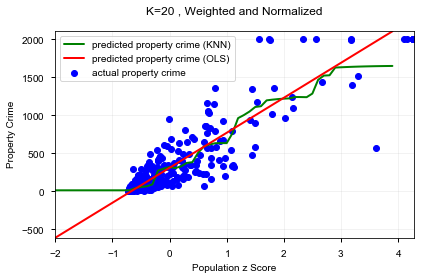

====================================KNN SCore==========================
Weighted Accuracy: 0.79 (+/- 0.17)
====================================OLS SCore==========================
R-squared:
0.8245298975884883


In [4]:
# Instantiate and fit our model.
#Create regr instance
regr = linear_model.LinearRegression()

# Run the same model, this time with weights.
d_n_neighbors = 20
knn_w = neighbors.KNeighborsRegressor(n_neighbors=d_n_neighbors, weights='distance')

# Our input data frame will be the z-scores this time instead of raw data.
X = pd.DataFrame({
    'Pop': stats.zscore(df3.Pop),    
    'Murder_feat': stats.zscore(df3.Murder_feat),
    'Robbery_feat': stats.zscore(df3.Robbery_feat)
})
Y = df3.Prop_cr

# Set up our prediction line.
T = np.arange(-2, 4, 0.1)
S = np.array(T)
ll = pd.DataFrame()
ll['a'] = S
ll['b'] = S
ll['c'] = S
X_axis = T[:, np.newaxis]

#Train KNN
knn_w.fit(X, Y)

#Train OLS
regr.fit(X, Y)

#Predict KNN
Yknn_ = knn_w.predict(ll)

#Predict OLS
Yols_ = regr.predict(ll)

#Plot
fig,ax = plt.subplots(1,1)
ax.scatter(X['Pop'], Y, c='b', label='actual property crime')
ax.plot(X_axis, Yknn_, marker='+', c='g', label='predicted property crime (KNN)')
ax.plot(X_axis, Yols_, marker='+', c='r', label='predicted property crime (OLS)')
ax.legend()
ax.set_title('K=' + str(d_n_neighbors) + ' , Weighted and Normalized', y=1.05,size=12)
ax.set_xlabel('Population z Score', labelpad=5, size=10)
ax.set_ylabel('Property Crime', labelpad=5, size=10)
plt.show()

#Print parms
print("====================================KNN SCore==========================")
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))
print("====================================OLS SCore==========================")
print('R-squared:')
print(regr.score(X, Y))
print("=======================================================================")

In [5]:
correlation_matrix = df3.corr()
display(correlation_matrix)

,Pop,Pop2,Murder_feat,Robbery_feat,Violent_cr,Agg_asslt,Burg,Larc_thft,Mtr_vhcl_thft,Prop_cr
Pop,1.000,0.958,0.551,0.425,0.758,0.776,0.840,0.825,0.830,0.901
Pop2,0.958,1.000,0.490,0.300,0.745,0.699,0.797,0.714,0.819,0.855
Murder_feat,0.551,0.490,1.000,0.313,0.603,0.598,0.595,0.557,0.560,0.574
Robbery_feat,0.425,0.300,0.313,1.000,0.304,0.476,0.402,0.552,0.332,0.453
Violent_cr,0.758,0.745,0.603,0.304,1.000,0.783,0.913,0.689,0.933,0.825
Agg_asslt,0.776,0.699,0.598,0.476,0.783,1.000,0.835,0.850,0.757,0.844
Burg,0.840,0.797,0.595,0.402,0.913,0.835,1.000,0.839,0.917,0.943
Larc_thft,0.825,0.714,0.557,0.552,0.689,0.850,0.839,1.000,0.745,0.930
Mtr_vhcl_thft,0.830,0.819,0.560,0.332,0.933,0.757,0.917,0.745,1.000,0.876
Prop_cr,0.901,0.855,0.574,0.453,0.825,0.844,0.943,0.930,0.876,1.000


In [6]:
print("Percent of Zeros\n================================")
print("Violent_cr {:0.2f}".format(df[(df['Violent_cr']==0)].shape[0]/df.shape[0]))
print("Mrdr_manslter {:0.2f}".format(df[(df['Mrdr_manslter']==0)].shape[0]/df.shape[0]))
print("Rape2 {:0.2f}".format(df[(df['Rape2']==0)].shape[0]/df.shape[0]))
print("Robbery {:0.2f}".format(df[(df['Robbery']==0)].shape[0]/df.shape[0]))
print("Agg_asslt {:0.2f}".format(df[(df['Agg_asslt']==0)].shape[0]/df.shape[0]))
print("Prop_cr {:0.2f}".format(df[(df['Prop_cr']==0)].shape[0]/df.shape[0]))
print("Burg {:0.2f}".format(df[(df['Burg']==0)].shape[0]/df.shape[0]))
print("Larc_thft {:0.2f}".format(df[(df['Larc_thft']==0)].shape[0]/df.shape[0]))
print("Mtr_vhcl_thft {:0.2f}".format(df[(df['Mtr_vhcl_thft']==0)].shape[0]/df.shape[0]))
print("Arson3 {:0.2f}".format(df[(df['Arson3']==0)].shape[0]/df.shape[0]))

Percent of Zeros
Violent_cr 0.15
Mrdr_manslter 0.86
Rape2 0.59
Robbery 0.40
Agg_asslt 0.19
Prop_cr 0.02
Burg 0.06
Larc_thft 0.02
Mtr_vhcl_thft 0.27
Arson3 0.84


# Algorithm Evaluation

### Engineer your features, then create three models. Each model will be run on a training set and a test-set.
### The models should be:

### 1. Vanilla logistic regression
### 2. Ridge logistic regression
### 3. Lasso logistic regression

### In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

In [7]:
#Data

df4=pd.DataFrame()

# X variables
df4['Pop'] = df_jittered2['Pop']
df4['Pop2'] = df_jittered2['Pop_squared']
df4['Murder_feat'] = features['Murder_feat']
df4['Robbery_feat'] = features['Robbery_feat']
df4['Violent_cr'] = df_jittered2['Violent_cr']
df4['Agg_asslt'] = df_jittered2['Agg_asslt']
df4['Burg'] = df_jittered2['Burg']
df4['Larc_thft'] = df_jittered2['Larc_thft']
df4['Mtr_vhcl_thft'] = df_jittered2['Mtr_vhcl_thft']
df4['Prop_cr'] = df_jittered2['Prop_cr']

# Y variable
df4['Rape2_feat'] = features['Rape2_feat'] 



## Logistic Regression

## Logistic Regression Training

In [8]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.1.


In [9]:
# Define the training and test sizes.
trainsize = int(df4.shape[0] / 2)
df_test = df4.iloc[trainsize:, :].copy()
df_train = df4.iloc[:trainsize, :].copy()

Y_train = df_train['Rape2_feat'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['Rape2_feat'])]

# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.

lr = LogisticRegression(C=1e9,penalty='elasticnet',solver='saga',l1_ratio=0.7,random_state=12571)


# Fit the model.
fit = lr.fit(X_train, Y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X_train)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, df_train['Rape2_feat']))

print('\n Percentage accuracy')
print(lr.score(X_train, Y_train))

Coefficients
[[-1.34094905e-14  4.78957486e-10  2.23736056e-18 -1.28154550e-18
   4.33723887e-16  1.92026068e-16  5.24468420e-16  1.73445838e-15
   6.26539342e-17  2.15210593e-15]]
[-1.99566341e-17]

 Accuracy by admission status
Rape2_feat    0   1
row_0              
1           107  67

 Percentage accuracy
0.3850574712643678


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Logistic Regression Testing

In [10]:
# Test.
Y_test = df_test['Rape2_feat'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['Rape2_feat'])]
# Fit the model.
fit = lr.fit(X_test, Y_test)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, df_test['Rape2_feat']))

print('\n Percentage accuracy')
print(lr.score(X_test, Y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients
[[-8.71965653e-14  1.51932630e-09  3.89775850e-18 -1.77883824e-18
   6.03623300e-16  1.85062974e-16  6.51265006e-16  2.75814888e-15
   9.27137213e-17  3.85027121e-15]]
[-4.08769026e-17]

 Accuracy by admission status
Rape2_feat   0   1
row_0             
1           97  77

 Percentage accuracy
0.4425287356321839


## Ridge Regression

# Ridge Training

In [11]:
# Set up the regression model to predict.
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)

print('\nR-squared:')
print(ridgeregr.score(X_train, Y_train))
print('\nParameter Estimates:')
print(ridgeregr.coef_)
print('Intercept:')
print(ridgeregr.intercept_)


R-squared:
0.41861346159804397

Parameter Estimates:
[[ 1.39575909e-05 -1.59862607e-10 -1.20478848e-02  1.12823761e-01
  -3.21112817e-04  1.89239010e-02  8.62449785e-04  4.30117116e-04
  -2.28198956e-03 -3.77412780e-04]]
Intercept:
0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.486963e-20
  overwrite_a=True).T


## Ridge Testing

In [12]:
# Test.
ridgeregr.fit(X_test, Y_test)

print('\nR-squared:')
print(ridgeregr.score(X_test, Y_test))
print('\nParameter Estimates:')
print(ridgeregr.coef_)
print('Intercept:')
print(ridgeregr.intercept_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.375385e-20
  overwrite_a=True).T



R-squared:
0.4807159500625375

Parameter Estimates:
[[ 6.80868219e-06 -9.51122268e-11  1.97777248e-02  1.61604374e-01
  -1.53007751e-03  1.25260399e-02  2.13674305e-03  8.14490007e-04
  -1.85365710e-03 -2.97637207e-04]]
Intercept:
0.0


## Lasso Regression

# Lasso Training

In [13]:
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)

print('R² for the model:')
print(lass.score(X_train, Y_train))
print('\nParameter Estimates:')
print(lass.coef_)
print('Intercept:')
print(lass.intercept_)

R² for the model:
0.40491372484325255

Parameter Estimates:
[ 1.20857837e-05 -1.85434617e-10  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.23387888e-02  6.95549246e-05  5.41294635e-04
 -0.00000000e+00 -7.16823067e-05]
Intercept:
[0.09760888]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.489161146943772, tolerance: 0.004120114942528737
  positive)


## Lasso Testing

In [14]:
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_test, Y_test)

print('R² for the model:')
print(lass.score(X_test, Y_test))
print('\nParameter Estimates:')
print(lass.coef_)
print('Intercept:')
print(lass.intercept_)

R² for the model:
0.4449901368889215

Parameter Estimates:
[ 1.02019215e-05 -1.30320054e-10  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  3.84605171e-03  4.43183289e-04  1.36538167e-03
 -0.00000000e+00 -3.45226781e-04]
Intercept:
[0.09842777]


# END